In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.0/883.0 kB 36.6 MB/s eta 0:00:00


### Compilação e Treinamento do Modelo YOLOv8 para Detecção de Cabeça de Vaca



**Compilação do Modelo**: O YOLOv8, pré-treinado no modelo base yolov8s.pt, é configurado para a tarefa de detecção, utilizando o arquivo de dados data.yaml, que contém as anotações e a estrutura do conjunto de dados. O modelo é otimizado com o otimizador Adam ou SGD, e a taxa de aprendizado pode ser ajustada conforme necessário. A função de perda usada inclui a detecção de caixas delimitadoras e a classificação de objetos, adequada para identificar a cabeça de vaca nas imagens.

**Treinamento do Modelo**: O treinamento é realizado com 25 épocas, usando imagens redimensionadas para 128x128 pixels (imgsz=128). O conjunto de dados é especificado no arquivo data.yaml, que define as classes e os caminhos para as imagens e anotações. O progresso do treinamento é salvo no projeto runs/detect com o nome detect_head_cow. Durante o treinamento, o modelo ajusta suas previsões e otimiza suas capacidades de detectar cabeças de vacas nas imagens.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import xml.etree.ElementTree as ET

# Função que converte a máscara da cabeça em caixa delimitadora no formato YOLO
def mask_to_bbox(mask):
    """Converte uma máscara binária em uma caixa delimitadora no formato YOLO."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not np.any(rows) or not np.any(cols):
        return None

    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    x_center = (x_min + x_max) / 2 / mask.shape[1]  # Normalizando
    y_center = (y_min + y_max) / 2 / mask.shape[0]  # Normalizando
    width = (x_max - x_min) / mask.shape[1]  # Normalizando
    height = (y_max - y_min) / mask.shape[0]  # Normalizando

    return [x_center, y_center, width, height]

# Função para plotar a caixa delimitadora na imagem
def plot_bbox(image, bbox):
    """Plota a imagem e a caixa delimitadora."""
    x_center, y_center, width, height = bbox
    img_height, img_width = image.shape[:2]

    # Convertendo as coordenadas normalizadas para pixels
    x_min = int((x_center - width / 2) * img_width)
    x_max = int((x_center + width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    y_max = int((y_center + height / 2) * img_height)

    # Plotando a imagem e a caixa delimitadora
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                       edgecolor='red', facecolor='none', linewidth=2))
    plt.axis('off')
    plt.show()

def process_images(frame_subfolders, frame_offsets):
    os.makedirs('datasets/images/train', exist_ok=True)
    os.makedirs('datasets/labels/train', exist_ok=True)
    os.makedirs('datasets/images/val', exist_ok=True)
    os.makedirs('datasets/labels/val', exist_ok=True)
    num_excep = 0
    for idx, subfolder_info in enumerate(frame_subfolders):
        frames_folder = subfolder_info['folder']
        xml_file = subfolder_info['xml']
        frame_offset = frame_offsets[idx]

        # Verifica se a subpasta e o arquivo XML existem
        if not os.path.exists(frames_folder) or not os.path.exists(xml_file):
            print(f"Pasta {frames_folder} ou arquivo {xml_file} não encontrado. Pulando.")
            continue

        # Parseia o arquivo XML correspondente
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Percorre todas as imagens descritas no XML
        for image_info in root.findall('.//image'):
            image_id = int(image_info.get('id'))
            frame_number = frame_offset + image_id  # Começa em 0000
            image_name = f"frame_{frame_number:04d}.png"  # Formato de 4 dígitos, começando em 0000
            image_path = os.path.join(frames_folder, image_name)

            # Verifica se a imagem existe
            if not os.path.exists(image_path):
                print(f"Imagem {image_name} não encontrada na pasta {frames_folder}. Pulando para a próxima.")
                continue

            # Carrega a imagem
            image = cv2.imread(image_path)

            # Cria uma máscara binária da cabeça
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

            # Busca as caixas da "cabeça" e "contexto"
            for box in image_info.findall('box'):
                label = box.get('label')

                if label == "cabeca":
                    cabeca_coords = (
                        int(float(box.get('xtl'))),
                        int(float(box.get('ytl'))),
                        int(float(box.get('xbr'))),
                        int(float(box.get('ybr')))
                    )
                    cv2.rectangle(mask, (cabeca_coords[0], cabeca_coords[1]), (cabeca_coords[2], cabeca_coords[3]), 255, -1)

            # Converte a máscara em bounding box no formato YOLO
            bbox = mask_to_bbox(mask)
            if bbox is None:
              num_excep += 1
            if bbox is not None:
                # Salvando a imagem na pasta de treino
                img_output_path = f'datasets/images/train/{image_name}'
                cv2.imwrite(img_output_path, image)

                # Salvando a anotação da bounding box no formato YOLO
                label_output_path = f'datasets/labels/train/{image_name.replace(".png", ".txt")}'
                with open(label_output_path, 'w') as f:
                    f.write(f"0 {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

            if num_excep >100:
              num_excep = 0
              break

            print(f"Processado: {image_name}, bbox: {bbox if bbox else 'Nenhuma bounding box encontrada'}")


# Definir a lista de subpastas e offsets conforme no seu código original
frame_subfolders = [
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_1', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_1.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_2', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_2.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_3', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_3.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_4', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_4.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_5', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_5.xml', 'video_code': '00000000205000000'}
]
frame_offsets = [0, 1282, 2564, 3846, 5353]

# Processar as imagens
process_images(frame_subfolders, frame_offsets)


Processado: frame_0000.png, bbox: [0.3425925925925926, 0.6347222222222222, 0.18444444444444444, 0.275]
Processado: frame_0001.png, bbox: [0.15814814814814815, 0.6453703703703704, 0.30444444444444446, 0.4351851851851852]
Processado: frame_0002.png, bbox: [0.47074074074074074, 0.4217592592592593, 0.24074074074074073, 0.5231481481481481]
Processado: frame_0003.png, bbox: [0.22555555555555556, 0.47685185185185186, 0.25555555555555554, 0.42777777777777776]
Processado: frame_0004.png, bbox: [0.29814814814814816, 0.5060185185185185, 0.5962962962962963, 0.4287037037037037]
Processado: frame_0005.png, bbox: [0.27444444444444444, 0.7699074074074074, 0.2362962962962963, 0.24537037037037038]
Processado: frame_0006.png, bbox: Nenhuma bounding box encontrada
Processado: frame_0007.png, bbox: [0.3814814814814815, 0.49537037037037035, 0.6918518518518518, 0.37222222222222223]
Processado: frame_0008.png, bbox: [0.3488888888888889, 0.5763888888888888, 0.5525925925925926, 0.3175925925925926]
Processado: f

In [ ]:
import shutil

train_images_dir = '/content/datasets/images/train'
train_labels_dir = '/content/datasets/labels/train'
val_images_dir = '/content/datasets/images/val'
val_labels_dir = '/content/datasets/labels/val'

# Lista todas as imagens de treino
image_files = sorted(os.listdir('/content/datasets/images/train'))

# Separo 25% para dados de validação
num_val_images = int(len(image_files) * 0.25)

# Move 25% das imagens e seus respectivos arquivos de anotação
for i in range(num_val_images):
    image_file = image_files[i]
    label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')

    # Move imagem
    shutil.move(os.path.join(train_images_dir, image_file), os.path.join(val_images_dir, image_file))

    # Move label
    shutil.move(os.path.join(train_labels_dir, label_file), os.path.join(val_labels_dir, label_file))

print(f"Movidos {num_val_images} imagens e labels para a pasta de validação.")

Movidos 90 imagens e labels para a pasta de validação.


In [ ]:
import yaml

# Defino os dados que serão salvos no arquivo YAML
data = {
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,  # Número de classes
    'names': ['head_cow']  # Lista de classes
}

# Caminho do arquivo YAML a ser criado
yaml_path = '/content/data.yaml'

# Crio e salvo o arquivo YAML
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

print(f"Arquivo YAML criado em: {yaml_path}")

Arquivo YAML criado em: /content/data.yaml


In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=25 imgsz=128 project=runs/detect name=detect_head_cow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 21.5M/21.5M [00:00<00:00, 156MB/s] 
Ultralytics 8.3.6 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/detect, name=detect_head_cow, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybri

In [ ]:
import shutil

# Caminho da pasta com o treinamento salvo
source = '/content/runs/detect/detect_head_cow'
# Caminho de destino no Google Drive para salvar o modelo
destination = '/content/drive/MyDrive/Colab Notebooks/data/detect_cow'
# Copia a pasta para o Google Drive
shutil.copytree(source, destination)


In [ ]:
import pandas as pd
# Printando resultados do modelo
pd.read_csv('/content/runs/detect/detect_head_cow/results.csv')

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.4218,3.64430,2.05350,0.00602,0.22222,0.00463,0.00136,3.4611,3.6559,2.0815,0.000340,0.000340,0.000340
1,2,2.3907,2.80560,1.37350,0.00655,0.30000,0.00528,0.00142,3.3073,3.7621,1.9551,0.000672,0.000672,0.000672
2,3,1.9830,1.76980,1.20880,0.01291,0.64444,0.01557,0.00431,2.9323,3.5830,1.9002,0.000976,0.000976,0.000976
3,4,2.0269,1.61910,1.21920,0.01112,0.66667,0.01382,0.00392,2.5184,3.5042,1.7606,0.001251,0.001251,0.001251
4,5,1.8447,1.49940,1.14940,0.00993,0.37778,0.02594,0.00658,3.0661,3.7313,2.3206,0.001498,0.001498,0.001498
5,6,1.7997,1.31200,1.12070,0.46737,0.03333,0.13609,0.03687,2.7925,3.3312,1.9760,0.001604,0.001604,0.001604
6,7,1.8384,1.34180,1.13740,0.24584,0.12222,0.08668,0.03137,2.6815,3.2098,1.9750,0.001525,0.001525,0.001525
7,8,1.5356,1.34000,1.02730,0.28895,0.16707,0.11039,0.03202,2.7908,3.1502,2.0311,0.001446,0.001446,0.001446
8,9,1.6251,1.28730,1.10260,0.20612,0.20000,0.12417,0.02940,2.8943,2.9288,2.0415,0.001366,0.001366,0.001366
9,10,1.5755,1.24030,1.08780,0.22601,0.13333,0.10289,0.02076,2.9568,2.8437,2.0358,0.001287,0.001287,0.001287



0: 128x128 1 head_cow, 7.9ms
Speed: 0.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 128, 128)


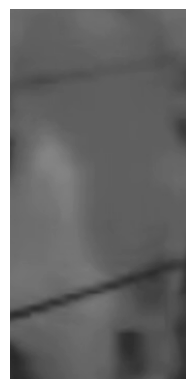

In [6]:
import cv2
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO

# Carrego o modelo treinado
model = YOLO('/content/drive/MyDrive/data/detect_cow/weights/best.pt')

# Defino a pasta onde os recortes serão salvos
output_dir = '/content/cropped_images'
os.makedirs(output_dir, exist_ok=True)

# Carrego a imagem para teste
image_path = '/content/frame_0008.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converto BGR para RGB

# Realizo a predição
results = model.predict(image_rgb)

# Processando os resultados
for i, result in enumerate(results):
    # Obtendo as coordenadas da bounding box
    for box in result.boxes:
        # Coordenadas x1, y1, x2, y2 da bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # Converte para inteiros

        # Recorto a área da imagem original (BGR)
        cropped_image = image[y1:y2, x1:x2]

        # Defino o caminho para salvar a imagem recortada
        crop_filename = os.path.join(output_dir, f'cropped_{i}_{x1}_{y1}.png')

        # Salvo o recorte na pasta de saída
        cv2.imwrite(crop_filename, cropped_image)

        # Opcional: Mostrar a imagem recortada
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


### Medição de Tempo de Treinamento, Inferência

Este código mede o tempo total de treinamento do modelo e o tempo médio de inferência por imagem no conjunto de validação.


0: 128x128 1 head_cow, 7.2ms
Speed: 0.6ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 128)


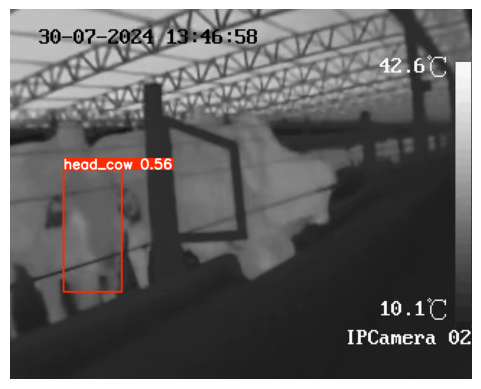

In [8]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Carrego seu modelo treinado
model = YOLO('/content/drive/MyDrive/data/detect_cow/weights/best.pt')

# Carrego a imagem para teste
image_path = '/content/frame_0008.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converto BGR para RGB

# Realizo a predição
results = model.predict(image)

# Exiba os resultados
for result in results:
    # Mostro a imagem com as predições
    plt.imshow(result.plot())  # Ploto a imagem com caixas delimitadoras
    plt.axis('off')
    plt.show()

In [4]:
import cv2
import os
from ultralytics import YOLO
from IPython.display import display, Video

# Carregar o modelo treinado
model = YOLO('/content/drive/MyDrive/data/detect_cow/weights/best.pt')

# Verificar se a pasta de destino existe
if not os.path.exists('/content/runs/detect/predict' ):
    os.makedirs('/content/runs/detect/predict' )

# Roda o modelo no vídeo e salvar o resultado no diretório de destino
results = model.predict(
    source='/content/drive/MyDrive/approach_nwot/videos/video_apresentação',
    conf=0.4,
    save=True
)

# O vídeo processado deve estar salvo em: /content/runs/detect/predict/
processed_video_path = os.path.join('/content/runs/detect/predict' , 'video_classification.mp4')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/3029) /content/drive/MyDrive/approach_nwot/videos/video_apresentação - Made with Clipchamp.mp4: 96x128 (no detections), 43.2

In [ ]:
!pip install wget

In [ ]:
# Importar o wget
import wget

# Definir a URL do arquivo que você quer baixar
url = '/content/runs/detect/predict2/video_preto_branco_10fps.avi'

# Baixar o arquivo
arquivo_baixado = wget.download(url)

# Exibir o nome do arquivo baixado
print(f'Arquivo baixado: {arquivo_baixado}')
